* This notebook was made to create three ferry routes shown in the map. 

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import matplotlib.cm as cm
import scipy.io as sio
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)

from datetime import datetime, timedelta
import glob
import os
from glob import glob
import datetime
import sys
import scipy.io as sio

sys.path.append('/ocean/jieliu/research/meopar/salinity_comparison/')
import research_ferries as rf

import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
%matplotlib inline

In [2]:
# Dictionary of ferry stations - new
ferry_stations = {'Tsawwassen': {'lat': 49.0084,'lon': -123.1281},
                  'Duke': {'lat': 49.1632,'lon': -123.8909},
                  'Vancouver': {'lat': 49.2827,'lon': -123.1207},
                 'Swartz': {'lat': 48.6882,'lon': -123.4102}}

In [3]:
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = bathy.variables['nav_lat']
lons = bathy.variables['nav_lon']
D = bathy.variables['Bathymetry']

day = datetime.datetime(2016,4,21)
run_date= datetime.datetime(2016,4,20)
date_str_yesterday = run_date.strftime('%Y%m%d')
saline=sio.loadmat('/ocean/jieliu/research/meopar/ONC_ferries/%s/%s_TSG%s.mat' %('HBDB', 'HBDB', date_str_yesterday))

* For larger map

In [4]:
#rivers info
test = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/rivers/rivers_cnst.nc','r')
plotting = test.variables['rorunoff'][0,:,:]
#Fraser River points
ifraser=[334,318]
jfraser=[414,434]
ls=['Fraser River',""]

def draw_rivers(ax,grid,lons_,lats_):
    for i in range(0,898):
        for j in range(0,398):
            if plotting[i,j] > 0:
                if grid=='grid':
                    ax.plot(j,i,'ob',markersize=3)  
                elif grid=='map':
                    ax.plot(lons_[i,j],lats_[i,j],'og',markersize=3,rasterized=True) 

In [5]:
cmap = plt.get_cmap('Blues')
cmap.set_bad('burlywood')
def draw_bathy(ax,grid):
   
    if grid=='grid':
        mesh=ax.pcolormesh(D[:],cmap=cmap)

    elif grid=='map':
        mesh=ax.pcolormesh(lons[:],lats[:],D[:],cmap=cmap)
        mesh=ax.contourf(lons[:],lats[:],D[:],15,cmap=cmap)
    
    viz_tools.plot_coastline(ax,bathy,coords=grid)   
    #cbar=fig.colorbar(mesh,ax=ax)
    #ax.set_aspect(5/4.4)

In [12]:
def plot_wholemap(cmap,bad,g):
    """
    """
    fig,axs = plt.subplots(1,2,figsize = (18,8))
    ax =axs[0]
    cmap.set_bad(bad)
    ## draw basemaps
    m = Basemap(projection= 'lcc', lat_0 = 50., lon_0 = -125.5,resolution = 'h',\
                  llcrnrlon = -129, urcrnrlon = -120,llcrnrlat = 46,urcrnrlat = 52,ax = ax)

    m.drawcoastlines()
    m.fillcontinents(color = 'burlywood',alpha=0.5)
    m.drawmeridians(np.arange(-129, -119, 2), labels = [0,0,0,1],fontsize = 16)
    m.drawparallels(np.arange(46,53,1), labels = [1,0,0,0],fontsize = 16)
    lons_, lats_ = m(lons[:], lats[:]) ## lon, lat conversion
    ## plot salinity mesh
    mesh=m.pcolormesh(lons_[:],lats_[:],D[:],cmap=cmap)
    mesh=m.contourf(lons_[:],lats_[:],D[:],15,cmap=cmap)
    cbar_ax = fig.add_axes([0.175, 0.0, 0.7, 0.05])
    cbar = fig.colorbar(mesh, cax=cbar_ax,orientation = 'horizontal')
    #ax.set_aspect(5/4.4)
    cbar.set_label('{depth.long_name} [{depth.units}]'.format(depth=D))
    
    viz_tools.plot_coastline(ax,bathy,coords=g)   

    draw_rivers(ax,g,lons_,lats_)
    ## add texts
    ax.text(0.05,0.4,'Pacific Ocean', fontsize=24,transform = ax.transAxes)
    ax.text(0.65,0.05,'Washington \n State', fontsize=24,transform = ax.transAxes)
    ax.text(0.8,0.2,'Puget \n Sound', fontsize=20,transform = ax.transAxes)
    ax.text(0.26,0.65,'Vancouver Island', fontsize=20,rotation=-32,transform = ax.transAxes)
    ax.text(0.66,0.7,'British \n Columbia',fontsize=26,transform = ax.transAxes)
    ax.text(0.41,0.4,'Juan de Fuca Strait',fontsize=16,rotation=-13,transform = ax.transAxes,color = 'r')
    ax.text(0.5,0.59,'Strait of Georgia',fontsize=18,rotation=-38,transform = ax.transAxes,color = 'r')
    ## plot subdomain
    ax = axs[1]
    ax = plot_ferrymap(ax,bad)
    ax = plot_ctd(ax)
    return fig

In [7]:
def plot_ferrymap(ax,bad):
    """
    """
    draw_bathy(ax, 'map')
    bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.8)
    stationsTWDP=['Tsawwassen','Duke']
    #stationsHBDB=['Horseshoe Bay','Duke']
    stationsTWSB=['Swartz','Vancouver']
    routes = ['TWDP','TWSB']
    colors = cm.rainbow(np.linspace(0, 1, len(routes)))
    
    for stn in stationsTWDP:
        ax.plot(ferry_stations[stn]['lon'], ferry_stations[stn]['lat'], marker='D', \
                    color='m', markersize=10, markeredgewidth=2)
        
        
    for stn in stationsTWSB:
        ax.plot(ferry_stations[stn]['lon'], ferry_stations[stn]['lat'], marker='D', \
                    color='m',markersize=10, markeredgewidth=2)
    ## add text  
    ax.annotate ('Tsawwassen',(ferry_stations['Tsawwassen']['lon'] + 0.042,\
    ferry_stations['Tsawwassen']['lat'] + 0.032), fontsize=20, color='black', bbox=bbox_args )
    ax.annotate ('Swartz Bay',(ferry_stations['Swartz']['lon'] - 0.4,\
    ferry_stations['Swartz']['lat'] - 0.1 ),fontsize=20, color='black', bbox=bbox_args )
    ax.annotate ('Vancouver',(ferry_stations['Vancouver']['lon'] + 0.07,\
    ferry_stations['Vancouver']['lat'] ),fontsize=20, color='black', bbox=bbox_args )
    ax.annotate ('Duke Point',(ferry_stations['Duke']['lon'] - 0.48,\
    ferry_stations['Duke']['lat'] ),fontsize=20, color='black', bbox=bbox_args )

    
    for route in routes:
        saline=sio.loadmat('/ocean/jieliu/research/meopar/ONC_ferries/%s/%s_TSG%s.mat' \
                           %(route, route, date_str_yesterday))
        lon11, lat11 = rf.find_route(saline, route, day)
        ax.plot(lon11,lat11,color='k', linewidth = 5)
    ax.set_xlim([-124.5,-122.5])
    ax.set_ylim([48.2,49.5])
    ax.set_axis_bgcolor(bad)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude') 
    return ax

In [8]:
def plot_ctd(ax):
    """
    """
    ## add Sandheads and VENUS Central
    x = -123.3; y = 49.1;
    name = 'Sandheads'
    ax.plot(x,y,'ro',label = name, markersize= 10)
    
    name = 'VENUS Central'
    ax.plot(-123.4261,49.0401,'ko',label = name, markersize= 10)   
    
    ## add ctd casts
    ax.plot(-123.527, 49.102666666666664,'*',markersize = 12,color = 'r')   
    ax.plot(-123.31033333333333, 49.16733333333333,'*',markersize = 12,color = 'g')  
    ax.plot(-123.62, 49.089666666666666,'*',markersize = 12,color = 'm')  
    ax.plot(-123.4385, 49.03,'*',markersize = 12,color = 'purple')  
    ax.plot(-123.37266666666666, 49.05466666666667,'*',markersize = 12,color = 'y')  
    ax.plot(-123.2119,49.12924,'*',markersize = 12,color = 'deeppink')  
    return ax

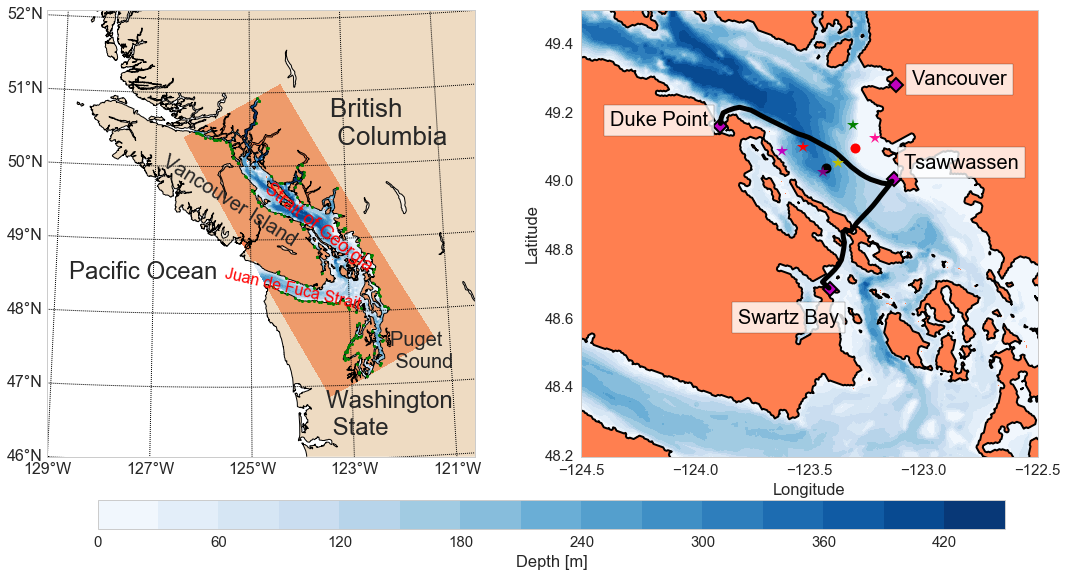

In [13]:
fig = plot_wholemap(cmap, 'coral','map')

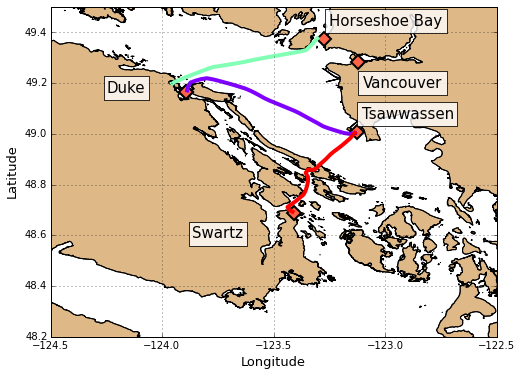

In [5]:
fig = salinity_ferry_route(bathy, PNW_coastline)

In [6]:
fig.savefig('ferryroute.png')